## SI 670 Applied Machine Learning, Week 5: Trees, Bagging, Boosting, Calibration .

In [0]:
# # run this cell if you are using Colab

# !rm -rf fruit_data_with_colors.txt
# !rm -rf adspy_shared_utilities.py
# !rm -rf CommViolPredUnnormalizedData.txt

# import io

# from google.colab import files as colab_files
# uploaded = colab_files.upload()
# files = {'fruit_data_with_colors.txt': io.BytesIO(uploaded['fruit_data_with_colors.txt'])}

# # upload 'fruit_data_with_colors.txt', 'adspy_shared_utilities.py', and 'CommViolPredUnnormalizedData.txt'

In [0]:
# run this cell if you are using Jupyter
files = {'fruit_data_with_colors.txt': 'fruit_data_with_colors.txt'}

Load and generate datasets

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

np.set_printoptions(precision=2)


fruits = pd.read_table(files['fruit_data_with_colors.txt'])

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X_fruits, y_fruits, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)


from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer, load_boston
from adspy_shared_utilities import load_crime_dataset

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# synthetic dataset for simple regression
from sklearn.datasets import make_regression

X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)

# synthetic dataset for more complex regression
from sklearn.datasets import make_friedman1
X_F1, y_F1 = make_friedman1(n_samples = 100,
                           n_features = 7, random_state=0)

# synthetic dataset for classification (binary) 
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)

# more difficult synthetic dataset for classification (binary) 
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8,
                       cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Boston housing dataset
boston = load_boston()
X_boston, y_boston = load_boston(return_X_y = True)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

## Calibration

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



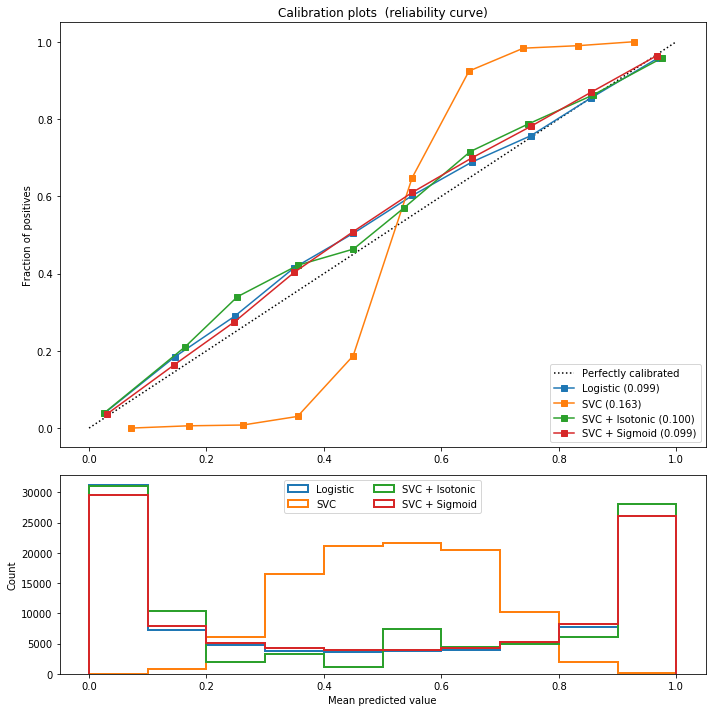

In [0]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()

## One-Hot Encoding

Let's get some hands-on experience with one-hot encoding.

First, we can discard the categories appearing in transform but not seen during fit.

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [0]:
enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [0]:
enc.transform([['Female', 1], ['Male', 4]]).toarray()

array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

Another example in inverse transform:

In [0]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

We can also get the feature names of the one-hot encoded features.

In [0]:
enc.get_feature_names()

array(['x0_Female', 'x0_Male', 'x1_1', 'x1_2', 'x1_3'], dtype=object)

We can also drop the first one-hot encoded column for each feature. One intuition behind is that we can use `k-1` binary variables to represent `k` categories.

In [0]:
drop_enc = OneHotEncoder(drop='first').fit(X)
drop_enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [0]:
drop_enc.transform([['Female', 1], ['Male', 2]]).toarray()

array([[0., 0., 0.],
       [1., 1., 0.]])

We can also convert the categorical feature into one-hot encoding using `ColumnTransformer`. If we want to one-hot encode column 1 and keep the rest columns unchanged, see below as an example.

In [0]:
from sklearn.compose import ColumnTransformer
enc_col_1 =ColumnTransformer([("Column 1", OneHotEncoder(),[0])], remainder="passthrough")
X_transformed = enc_col_1.fit_transform(X)
X_transformed

array([[0.0, 1.0, 1],
       [1.0, 0.0, 3],
       [1.0, 0.0, 2]], dtype=object)

### (Exercise) Convert the RAD feature of Boston housing data into one-hot encoding

In [0]:
print(boston.feature_names)
print(X_boston[:, boston.feature_names == 'RAD'].reshape(-1))

# %%% Your code: convert the 'RAD' column of X_boston to one-hot encoding. You should get 21 columns after transformation.

print(enc_boston.transformers_)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
[ 1.  2.  2.  3.  3.  3.  5.  5.  5.  5.  5.  5.  5.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.
  5.  5.  5.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.
  3.  5.  2.  5.  8.  8.  8.  8.  8.  8.  3.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  5.  4.  4.  4.  4.  3.  3.  3.  3.  2.  2.
  2.  2.  4.  4.  4.  2.  2.  2.  2.  2.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  2.  2.  2.  2.  2.  2.
  2.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  3.
  3.  3.  3.  3.  3.  3.  3.  5.  5.  5.  5.  5.  5.  1.  1.  4.  2.  2.
  2.  3.  3.  2.  2.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  5.  5.  5.  5.  8.  8.  8.  8.  8. 

## Decision Trees

In [0]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 3)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.97


#### Visualizing decision trees
From this figure, you can see the structure of decision trees and how decision trees generate the predictions.

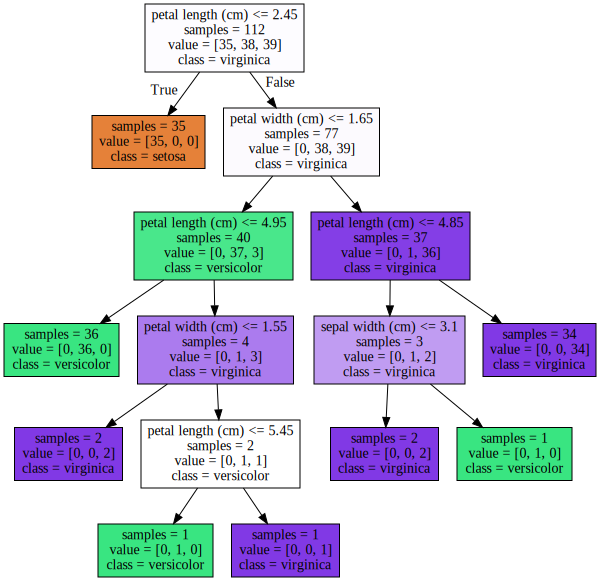

In [0]:
plot_decision_tree(clf, iris.feature_names, iris.target_names)

#### (Exercise) Setting max decision tree depth as 3 to help avoid overfitting

The training set accuracy `1.00` in the decision-tree classifier above indicates potential overfitting. Let's see if a maximum depth of 3 can help reduce the training set accuracy and alleviate overfitting.

In [0]:
clf2 = %%% Your code: fit a decision tree classifier with max_depth=3

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.98
Accuracy of Decision Tree classifier on test set: 0.97


#### Visualizing the pre-pruned version (max_depth = 3)

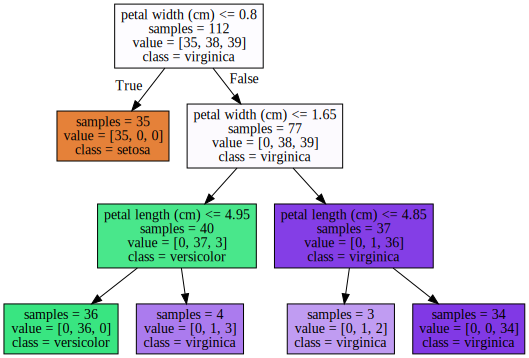

In [0]:
plot_decision_tree(clf2, iris.feature_names, iris.target_names)

#### Feature importances

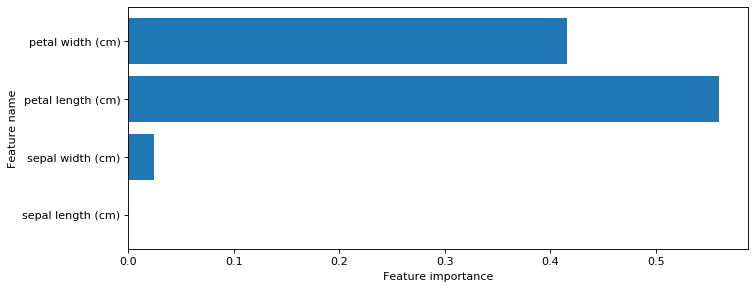

Feature importances: [0.   0.02 0.56 0.42]


In [0]:
from adspy_shared_utilities import plot_feature_importances

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, iris.feature_names)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

#### Visualizing the classificaiton boundary

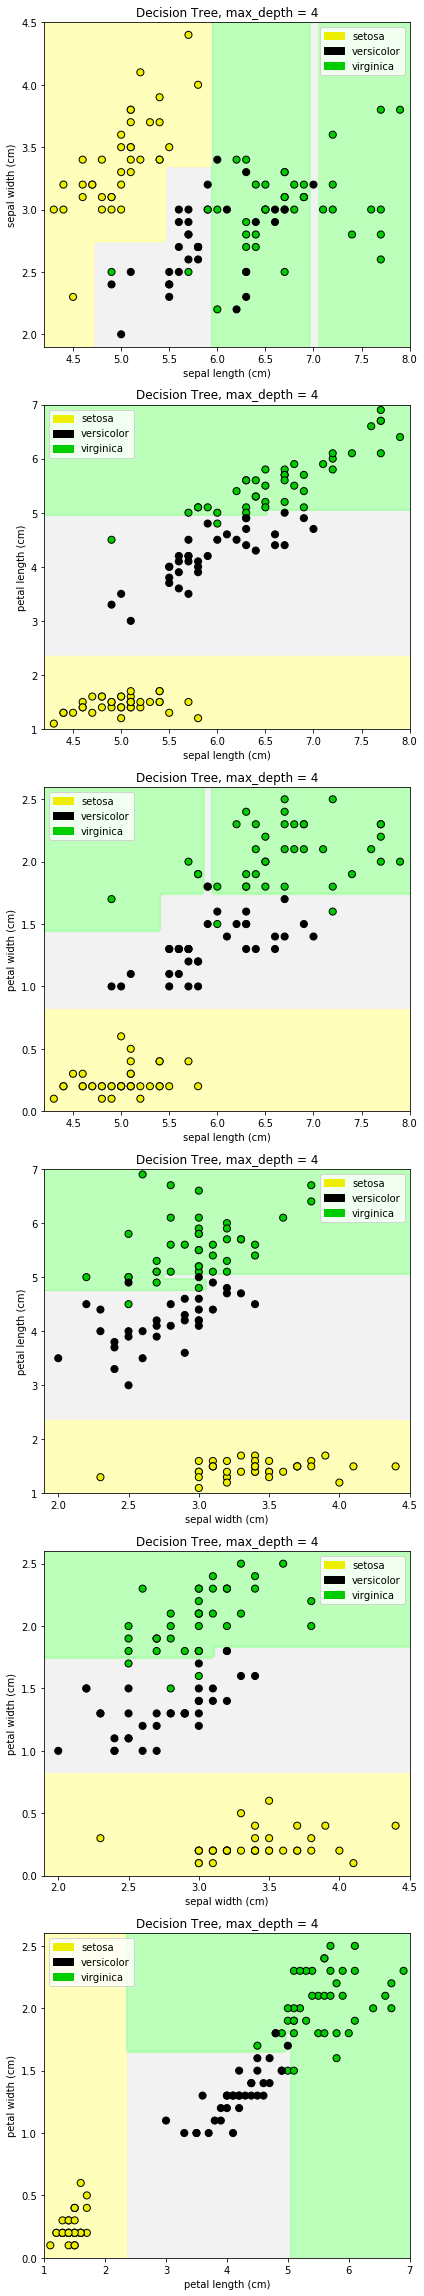

In [0]:
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
tree_max_depth = 4

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
    
    axis.set_xlabel(iris.feature_names[pair[0]])
    axis.set_ylabel(iris.feature_names[pair[1]])
    
plt.tight_layout()
plt.show()

#### (Exercise) Decision Trees on the breast cancer dataset

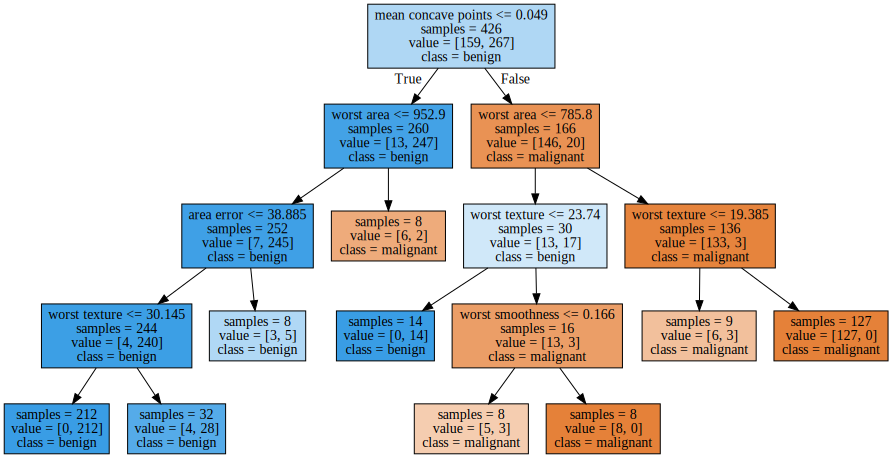

In [0]:
%%% Your code: split the (X_cancer, y_cancer )dataset and train a decision tree classifier (with max_depth=4 and min_samples_leaf=8)


plot_decision_tree(clf, cancer.feature_names, cancer.target_names)

Breast cancer dataset: decision tree
Accuracy of DT classifier on training set: 0.96
Accuracy of DT classifier on test set: 0.94


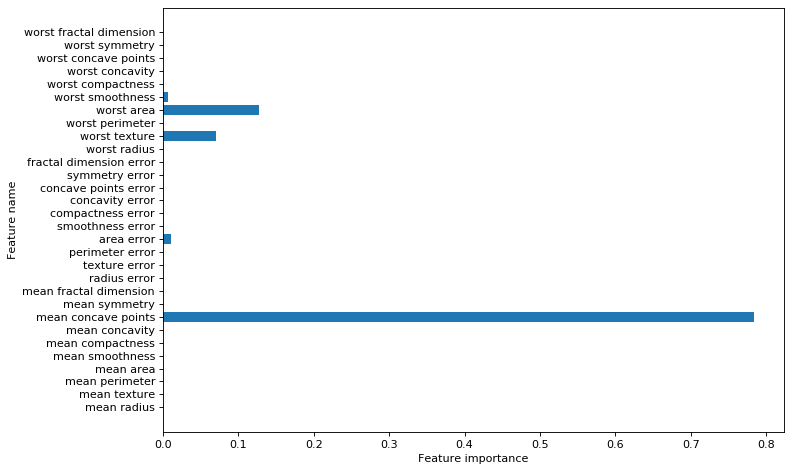

In [0]:
print('Breast cancer dataset: decision tree')
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(clf, cancer.feature_names)
plt.tight_layout()

plt.show()

## Bagging

### Random Forests

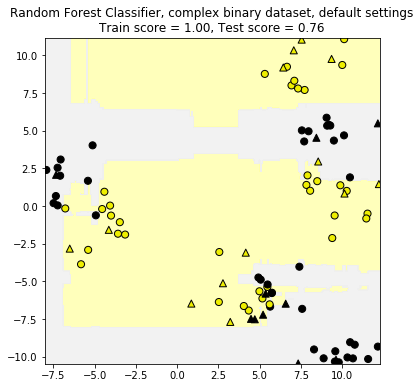

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

#### Random forests on the fruits dataset
We will first see how random forest makes predictions by each pair of features and then examine the performance by taking into account all features in the training set. 

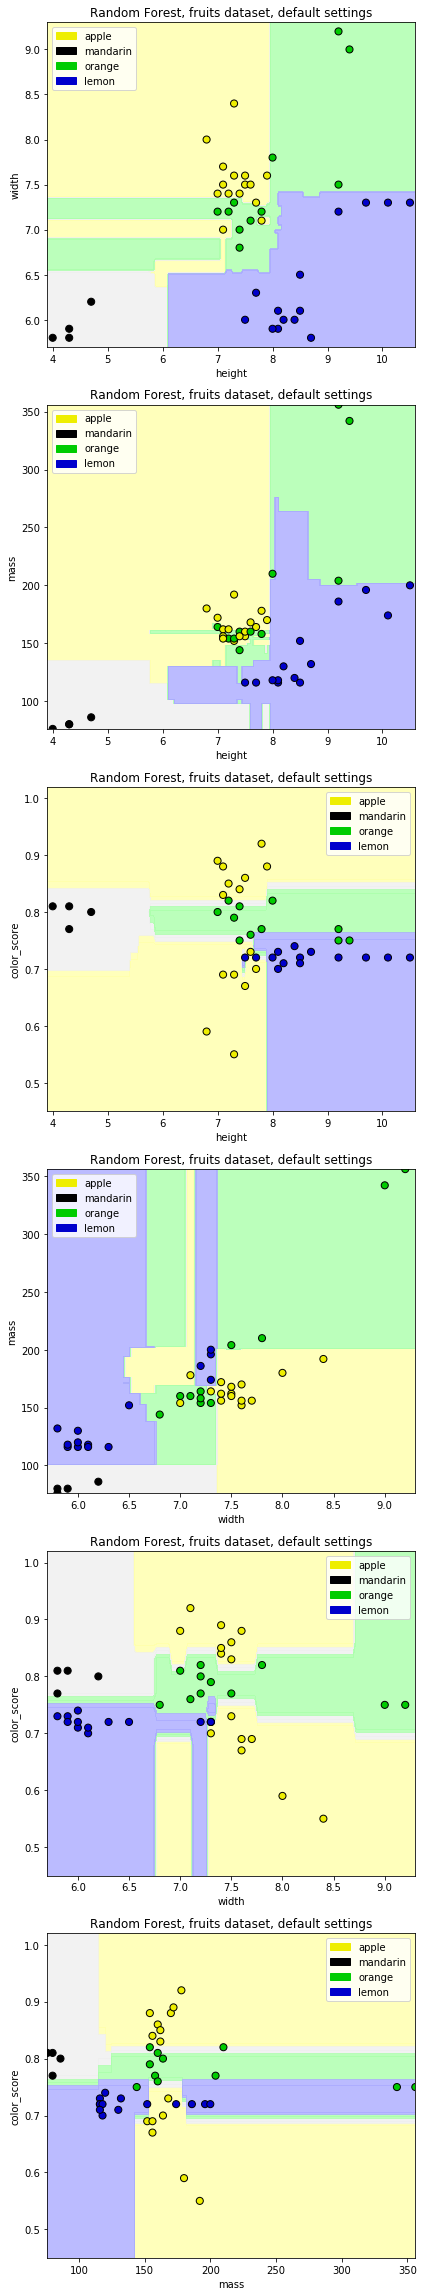

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_fruits.values,
                                                   y_fruits.values,
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = RandomForestClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()

clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

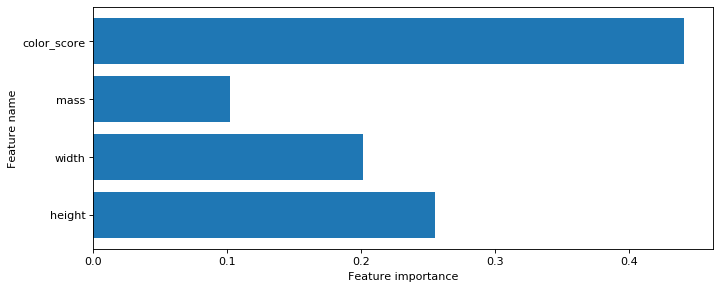

Feature importances: [0.26 0.2  0.1  0.44]


In [0]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, feature_names_fruits)
plt.show()
print('Feature importances: {}'.format(clf.feature_importances_))

#### (Exercise) Random forests on the breast cancer dataset

In [0]:
%%% Your code: split the (X_cancer, y_cancer) dataset and train a random forest classifier (with max_features=8 and random_state=0)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.99


## Boosting

### Gradient Boosting Trees

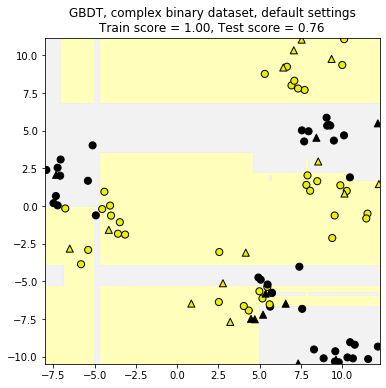

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

#### Gradient boosting trees on the fruits dataset

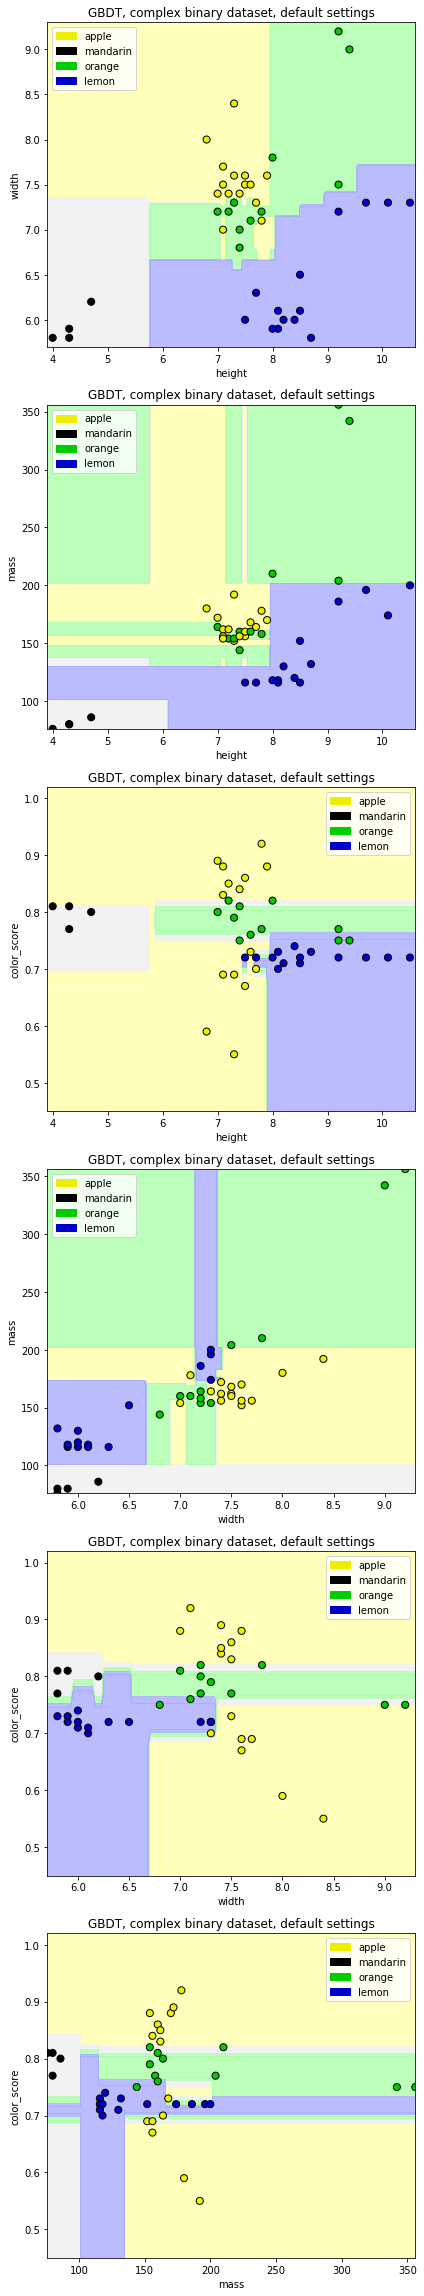

GBDT, Fruit dataset, default settings
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.80


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits.values,
                                                   y_fruits.values,
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('GBDT, Fruit dataset, default settings')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Gradient boosting trees on the breast cancer dataset

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset (learning_rate=0.1, max_depth=3)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.97

Breast cancer dataset (learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.97
Accuracy of GBDT classifier on test set: 0.97


### Adaboost

In this section, we are going to compare different classifiers with the help of visualization.

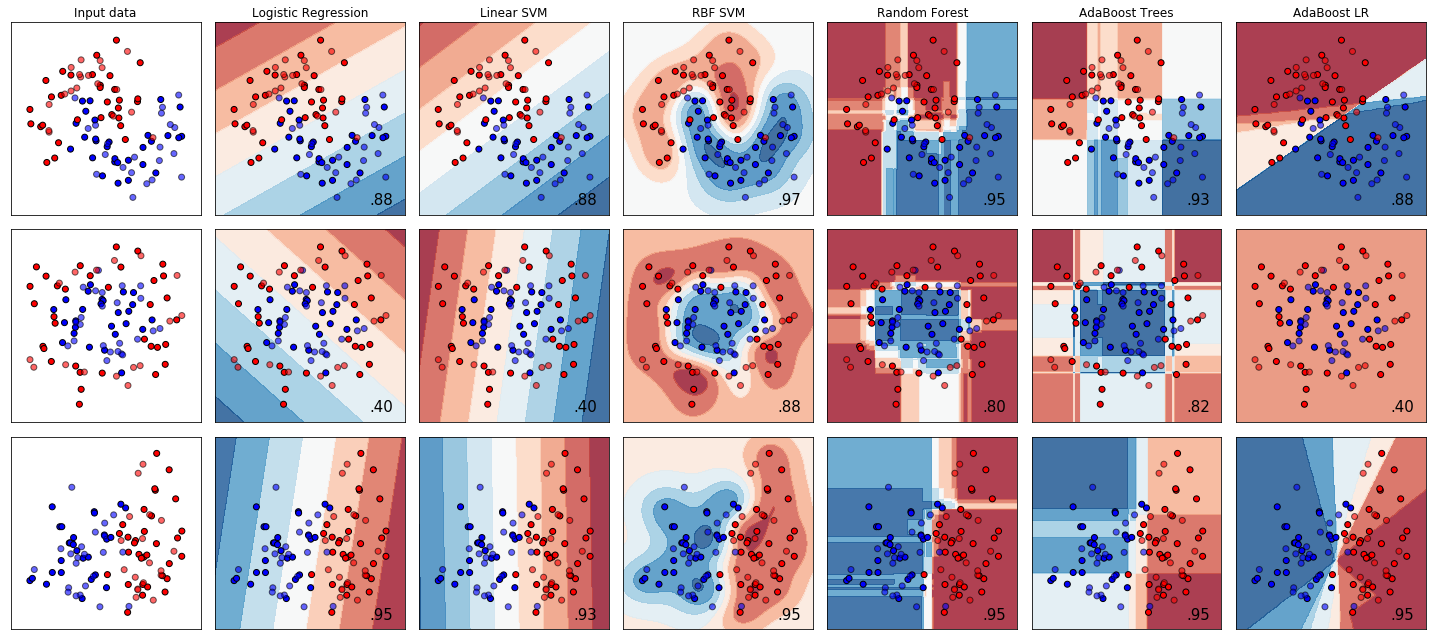

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

h = .02  # step size in the mesh

names = ["Logistic Regression", "Linear SVM", "RBF SVM", "Random Forest", "AdaBoost Trees", "AdaBoost LR"]

classifiers = [
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    AdaBoostClassifier(LogisticRegression(), algorithm="SAMME", n_estimators=10),]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(20, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

## (Exercise) Try random forests and boosting on the LFW dataset

Tune the hyper-parameters and see what's the best performance you can get.

In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.datasets import fetch_lfw_people

X_lfw, y_lfw = fetch_lfw_people(data_home='./', return_X_y=True, min_faces_per_person=70, resize=0.4)
X_train, X_test, y_train, y_test = train_test_split(X_lfw, y_lfw, random_state = 0)

In [0]:
%%% Your code here